Forme de X : (891, 11)
Forme de Y : (891,)
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Les meilleurs hyperparamètres sont :  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.82      0.90      0.85       105
           1       0.83      0.72      0.77        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179

L'accuracy-score :  0.8212290502793296


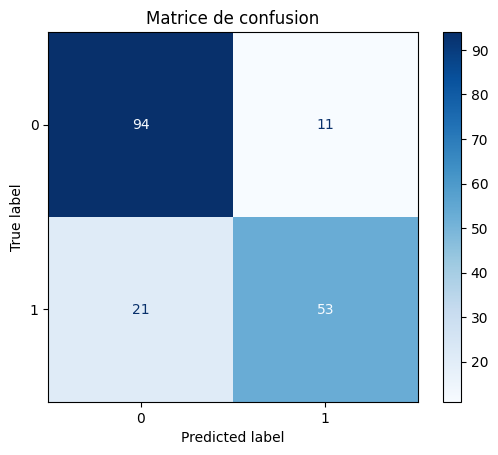

              precision    recall  f1-score   support

           0       0.82      0.90      0.85       105
           1       0.83      0.72      0.77        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179

Fichier de soumission généré : submission_titanic.csv


In [15]:
import pandas as pd
import numpy as np
import xgboost as xgb
from IPython.terminal.shortcuts.filters import PassThrough
from sklearn.impute import SimpleImputer
from pandas.api.types import is_numeric_dtype
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix , ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#Entrainement de notre model sur le set d'entrainement pour choix des meilleurs paramètres

df = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

#Encoder la database (supprimer les NaN et endoder les chaines de caractères)

drop = ['Cabin','Name','PassengerId','Ticket'] #Virer les colonnes qui servent à rien
df = df.drop(columns = drop)
passenger_id = df_test['PassengerId']
df_test = df_test.drop(columns = ['PassengerId','Ticket','Cabin','Name'])

num_cols = [c for c in df.columns if is_numeric_dtype(df[c])] #Trouver les colonnes numériques
other_cols = [c for c in df.columns if not is_numeric_dtype(df[c])] #Trouver les autres colonnes

num_cols_test = [c for c in df_test.columns if is_numeric_dtype(df_test[c])] #Trouver les colonnes numériques
other_cols_test = [c for c in df_test.columns if not is_numeric_dtype(df_test[c])] #Trouver les autres colonnes

OH_encoder = OneHotEncoder(sparse_output= False) #Initialisation de l'OH encoder

for col in other_cols : #On encode les chaines de caractères avec OH car peu de catégories
    encoded_features = OH_encoder.fit_transform(df[[col]])
    encoded_df = pd.DataFrame(encoded_features, columns=OH_encoder.get_feature_names_out([col]))
    df = pd.concat([df, encoded_df], axis=1).drop(columns=[col])

for col in other_cols_test:
    encoded_features = OH_encoder.fit_transform(df_test[[col]])
    encoded_df = pd.DataFrame(encoded_features, columns=OH_encoder.get_feature_names_out([col]))
    df_test = pd.concat([df_test, encoded_df], axis=1).drop(columns=[col])

cols_with_na = [c for c in num_cols if df[c].isna().any()] #Trouver les NaN
imputer = SimpleImputer(strategy='mean') #On va remplacer les NaN par la moyenne de la colonne
df[cols_with_na] = imputer.fit_transform(df[cols_with_na])

cols_with_na_test = [c for c in num_cols_test if df_test[c].isna().any()]
df[cols_with_na_test] = imputer.fit_transform(df[cols_with_na_test])


# Séparation des features (X) et de la target (Y)
Y = df['Survived']
X = df.drop(columns='Survived')

# Vérification des formes
print("Forme de X :", X.shape)
print("Forme de Y :", Y.shape)

# Séparation en train/test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

param_grid = { #Initialisation des différents hyperparamètres
    'n_estimators' : [50,100,150,200],
    'max_depth' : [3, 5, 7],
    'learning_rate' : [0.01 , 0.1 , 0.2]
}

model = xgb.XGBClassifier(random_state=42)

grid_search = GridSearchCV( #On cherche les meileurs combinaisons d'hyperparamètres
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1
)

grid_search.fit(X_train,Y_train)

best_model = grid_search.best_estimator_ #On choisit le meilleur
print("Les meilleurs hyperparamètres sont : ", grid_search.best_params_)

Y_pred = best_model.predict(X_test)
print(classification_report(Y_test,Y_pred))

#Evaluation du modèle

accuracy = accuracy_score(Y_test,Y_pred) #Calcul de l'accuracy du modèle
print("L'accuracy-score : ", accuracy)

cm = confusion_matrix(Y_test,Y_pred) #calcul de la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=best_model.classes_) #Affichage de la matrice de confusion
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion")
plt.show()

print(classification_report(Y_test,Y_pred)) #Métriques supplémentaires


df_test['Embarked_nan'] = 0

Y_pred_test = best_model.predict(df_test)
submission = pd.DataFrame({'PassengerId': passenger_id, 'Survived': Y_pred_test})
submission.to_csv("submission_titanic.csv", index=False)
print("Fichier de soumission généré : submission_titanic.csv")